# Custom locally weighted regression (loess/lowess) implementation
 

In [1]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

In [3]:
# Generate nonlinear data with outliers.
# Don't hesitate to change the generation parameters, method and data itself! Observe, how it changes results

n_samples = 1000
n_outliers = 100

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=True, random_state=1110)

In [4]:
print(X.shape, y.shape)

(1000, 1) (1000,)


In [5]:
# Replace first N samples with outliers

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

In [6]:
# Add non-linearity to data

y = y+100*X.T[0]*np.sin(X.T[0])

In [7]:
# Scale data to put in range [0,1] for stability.
# Check results if ignore it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())

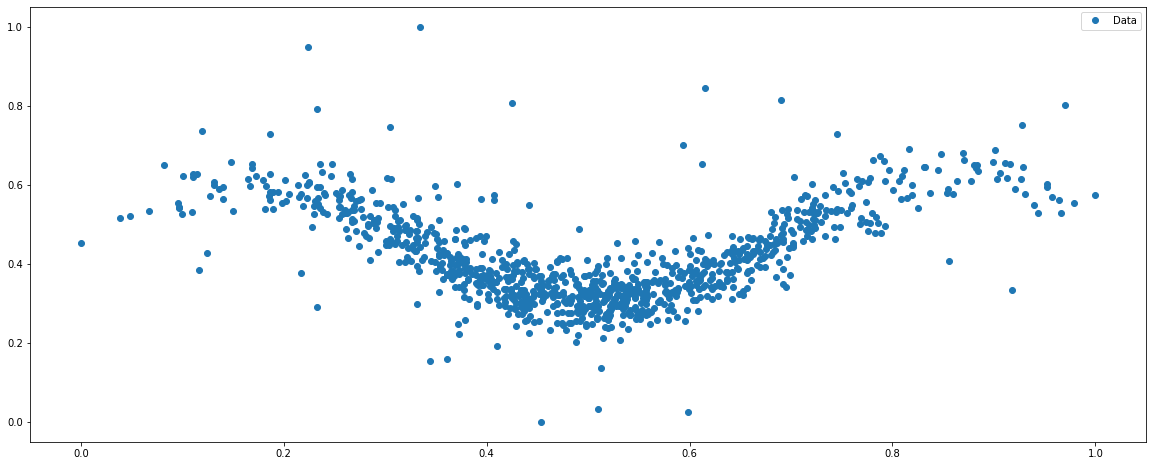

In [8]:
#visualize data
plt.plot(X, y, 'o', label = 'Data')
plt.legend()

# We will evaluate regression results by mape erorr

In [9]:
def mape(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape_value

### Custom locally weighted regression (loess/lowess)

In [10]:
# Gaussian kernel
def kernel(point, X, k):
    m,n = np.shape(X)
    weights = np.eye((m))
    
    for j in range(m):
        diff = point - X[j]
        weights[j, j] = np.exp(diff * diff.T / (-2.0 * k**2))
    
    return weights

In [11]:
def localWeight(point, X, y, k):
    wt = kernel(point, X, k)
    W = (X.T * (wt*X)).I * (X.T * wt * y.T)
    return W

In [12]:
def localWeightRegression(X, y, k):
    m,n = np.shape(X)
    ypred = np.zeros(m)
    
    for i in range(m):
        ypred[i] = X[i] * localWeight(X[i], X, y, k)
        
    return ypred

# for different k canculate predictions

In [13]:
predictions = []
for k in np.arange(0.1, 1, 0.1):
    colA = np.array(np.resize(X,(1000,)))
    colB = np.array(y)

    #using np.mat for linear algebra calculations
    mcolA = np.mat(colA)
    mcolB = np.mat(colB)


    m = np.shape(mcolB)[1]
    one = np.ones((1, m), dtype = int)

    # horizontal stacking
    X1 = np.hstack((one.T, mcolA.T))
    ypred = localWeightRegression(X1, mcolB, k)
    predictions.append(mape(y,ypred))
print(predictions)

[15.392049888852746, 19.52953188813801, 22.15552405041456, 23.778243142746515, 24.78133457135113, 25.38324659070364, 25.761387660509662, 26.013484865430247, 26.192759352146886]


### as we see k = 0.1 better for our data 

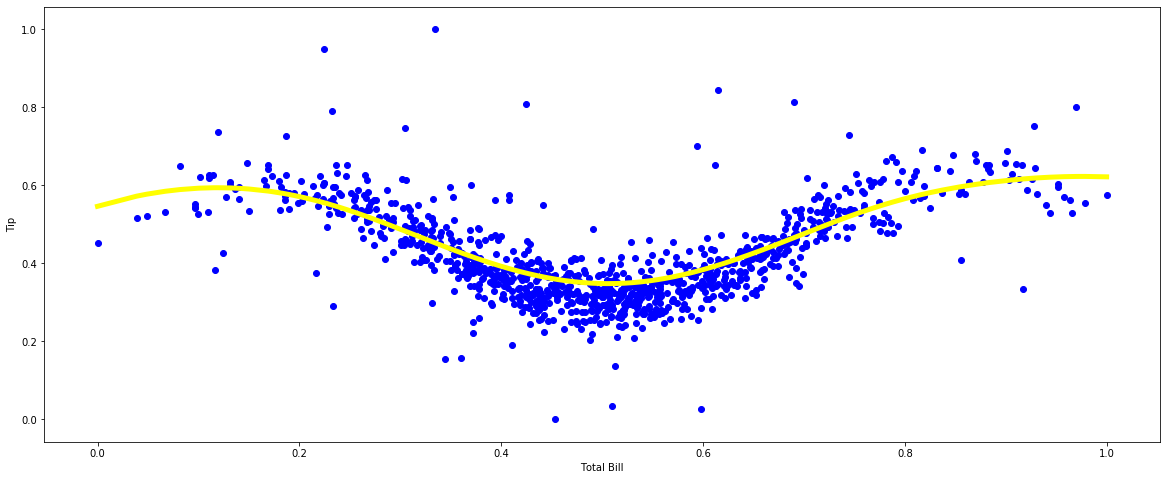

In [14]:

colA = np.array(np.resize(X,(1000,)))
colB = np.array(y)

#using np.mat for linear algebra calculations
mcolA = np.mat(colA)
mcolB = np.mat(colB)


m = np.shape(mcolB)[1]
one = np.ones((1, m), dtype = int)

# horizontal stacking
X1 = np.hstack((one.T, mcolA.T))
ypred = localWeightRegression(X1, mcolB, 0.1)


xsort = X1.copy()
xsort.sort(axis=0)
plt.scatter(colA, colB, color='blue')
plt.plot(xsort[:, 1], ypred[X1[:, 1].argsort(0)], color='yellow', linewidth=5)
plt.xlabel('Total Bill')
plt.ylabel('Tip')
plt.show()


In [15]:
#check shapes
print(y.shape,ypred.shape)

(1000,) (1000,)


In [16]:
loess = mape(y,ypred)


In [17]:
print(loess)

15.392049888852746


# Let's compare locally weighted regression with linear regression with polynomial feature engineering(polynom degree = 10) and linear model without feature engineering

In [18]:
def predict(X, theta):
    return np.dot(X, theta)

In [19]:
def objective_function(theta, X,y, loss_function=mape,lamda=100):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)

In [20]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

In [21]:
from scipy import optimize

In [22]:
def custom_regression(X, y, 
                      objective_function=objective_function, 
                      loss_function=mape, 
                      init = 1, 
                      verbose = True, 
                      iters = 10, lamda = 10):
  
    theta_init = np.ones_like(X[0]) * init
    result = optimize.minimize(objective_function,
                             args=(X, y, loss_function, lamda), 
                             x0 = theta_init, 
                             method='Powell', 
                             options={'maxiter': iters})
    theta = result['x']
    if verbose:
        print(result['fun'])
    return theta

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin 
from sklearn.preprocessing import PolynomialFeatures
class CustomRegression(BaseEstimator, RegressorMixin):                           
  def __init__(self, loss_function=mape, objective_function=objective_function): # all arguments should have default values
    self.theta = None # we don't know shape of theta on this stage
    # just save all variables taken during call to internal variables
    self.loss_function = loss_function 
    self.objective_function = objective_function
    
  def predict(self, X):
    return predict(X, self.theta)
  
  def score(self, X, y):
    return self.objective_function(theta=self.theta, X=X,y=y,loss_function=self.loss_function)
  
  def fit(self, X, y):
    if type(self.theta) == type(None):
      self.theta = np.ones_like(X[0])
    else:
      assert self.theta.shape == X[0].shape, "Model's shape doesn't fit input shape"
    self.theta = custom_regression(X, y, self.objective_function, self.loss_function, verbose = False)
    return self.score(X, y)
  
  def fit_predict(self, X, y):
    self.fit(X,y)
    return self.predict(X)
     

In [24]:
from sklearn.model_selection import train_test_split

# Split data to test and train in sklearn style
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [25]:
%%time
results = {}
row_results = {}
n=10
polynomial_features = PolynomialFeatures(degree = n, include_bias=True) # create instance of transformer
regression = CustomRegression() # create instance of model

# make pipeline as list of pairs (<stage name>, <stage object>):
pipeline = Pipeline([("polynomial_features", polynomial_features), # augment data
                       ("linear_regression", regression)]) # apply linear regression
  
# from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
pipeline.fit(X_train, y_train)

# Evaluate pipeline using crossvalidation and score() method
scores = cross_val_score(pipeline, X_train, y_train, cv=10)
  
# Make single evaluation on test set
test_scores = pipeline.score(X_test, y_test)

# Save results
results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
row_results[n] = scores



Wall time: 813 ms


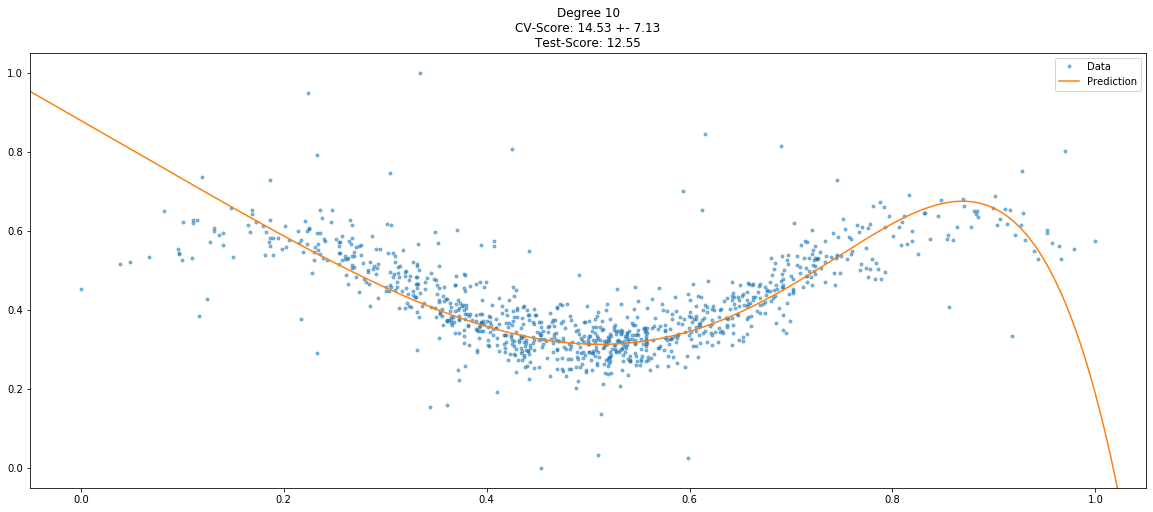

In [26]:
# Plot results
line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
line_y = pipeline.predict(line_x)
  

plt.plot(X, y, '.', alpha = 0.5, label = 'Data')
plt.autoscale(enable = False)
plt.plot(line_x, line_y, '-', label = 'Prediction')
plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'],results[n]['CV_std'],results[n]['Test']))
  
plt.legend()

In [27]:
poly = pipeline.score(X,y)

In [28]:
print(poly)

13.785881838139002


Wall time: 85.8 ms


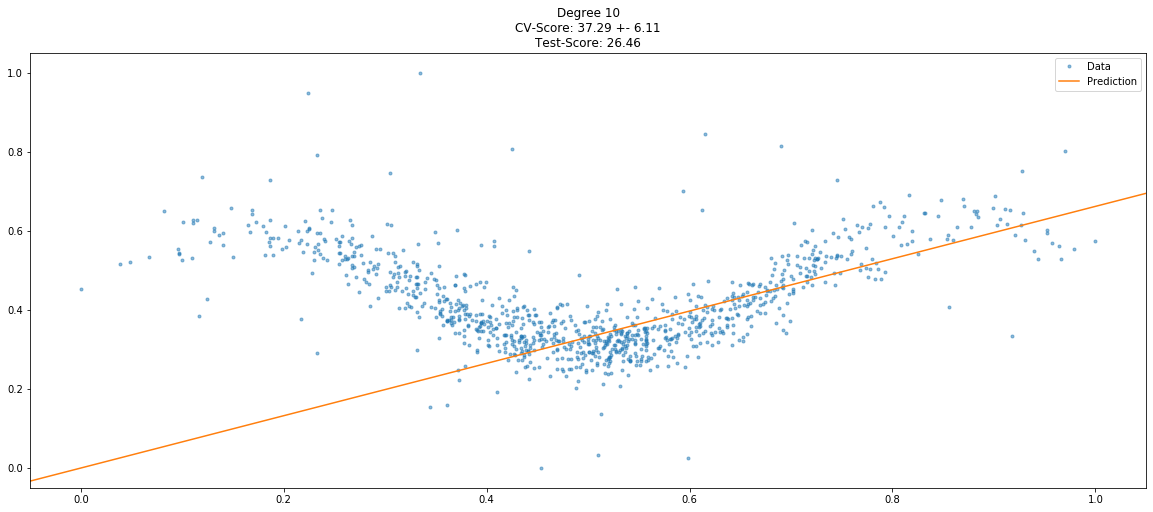

In [29]:
%%time
results = {}
row_results = {}

regression = CustomRegression() # create instance of model

# make pipeline as list of pairs (<stage name>, <stage object>):
pipeline2 = Pipeline([("linear_regression", regression)]) # apply linear regression
  
# from now we can treat pipeline as a single model, applying all stages when using fit() and predict() 
pipeline2.fit(X_train, y_train)

# Evaluate pipeline using crossvalidation and score() method
scores = cross_val_score(pipeline2, X_train, y_train, cv=10)
  
# Make single evaluation on test set
test_scores = pipeline2.score(X_test, y_test)

# Save results
results[n] = {'CV_mean':scores.mean(), 'CV_std':scores.std(), 'Test':test_scores}
row_results[n] = scores

# Plot results
line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
line_y = pipeline2.predict(line_x)
  

plt.plot(X, y, '.', alpha = 0.5, label = 'Data')
plt.autoscale(enable = False)
plt.plot(line_x, line_y, '-', label = 'Prediction')
plt.title("Degree %i\nCV-Score: %.2f +- %.2f\nTest-Score: %.2f"%(n, results[n]['CV_mean'],results[n]['CV_std'],results[n]['Test']))
  
plt.legend()

In [30]:
linear = pipeline2.score(X, y)

In [31]:
print(linear)

28.977266945419267


# In this case canculate mape loss on all input data not really demonstrative(cv score is better for choosing model) but for now we will compare locally weighted regression with linear regression with polynomial feature engineering(polynom degree = 10) by mape.

In [32]:
import pandas as pd
results ={}
results['loess']= {'MAPE':loess}
results['poly']= {'MAPE':poly}
results['linear']= {'MAPE':linear}

results = pd.DataFrame(results).T
results.style.highlight_min()

,MAPE
loess,15.392050
poly,13.785882
linear,28.977267


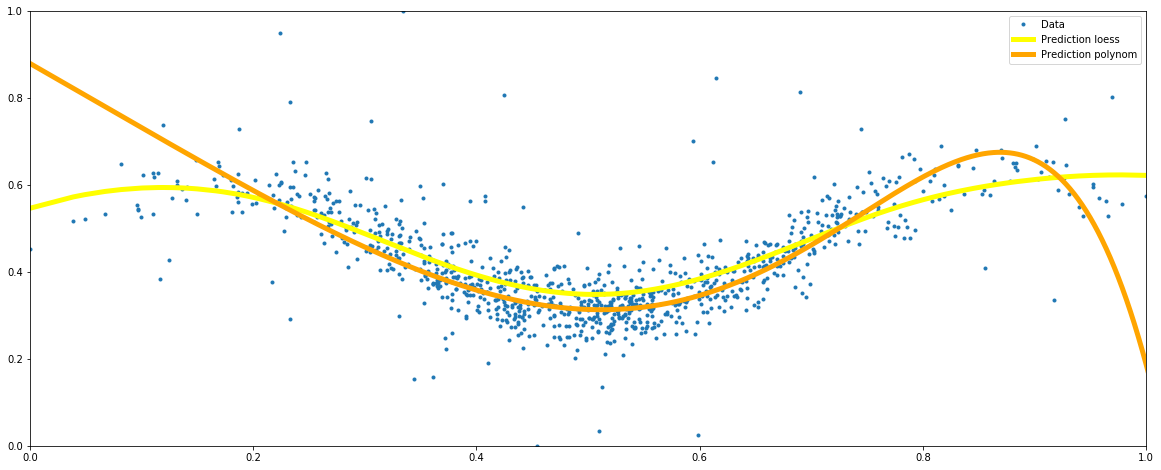

In [33]:
# Plot results

plt.autoscale(enable = False)
plt.plot(X, y, '.', label = 'Data')

plt.plot(xsort[:, 1], ypred[X1[:, 1].argsort(0)], color='yellow', linewidth=5, label = 'Prediction loess')
line_x = np.linspace(-0.1, 1.1, 1000).reshape(1000,1)
line_y = pipeline.predict(line_x)
plt.plot(line_x, line_y, '-', color='orange', linewidth=5, label = 'Prediction polynom')

 
plt.legend()

# Acording to Mape throughout the feature space linear regression with polynomial feature engineering is better for our data

## But if we look at plot loess can be more generalized or stable(attention to segment edges). We need to find ways for better evaluation

In [35]:
# Evaluation lowess in progress